# Final Group Project Report
**Ajay Antonio (90110792), Miria Cho (45167178), Lisa Zhang (5241548), Daniel Xu (17376179)**

# I. Introduction 

In this project, we will be tasked with analyzing a data set in collaboration with a research science group at UBC. Spearheaded by Frank Wood and his team, this project aims to provide insights into the relationships between online gaming and its users, highlighting the often arbitrary forms of data, such as the newsletter subscription, time logged in, and types of players. Through the use of different classification techniques and data recorded from a Minecraft server, we can then make conclusions for more efficient and targeted outreach to players.

The broad question that we will be aiming to tackle in our project is **What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?** 

More specifically, **Can we predict a player's chance to subscribe to the newsletter based on their total hours played, experience, and age?** In order to answer these questions, multiple steps must be taken to wrangle the data and carry out our predictions. More on this will be discussed later. 

## Data Description

We will be using the `players.csv` file given by DSCI 100, which provides detailed information and a list of all the unique players collected from the Minecraft Server. The data set has **196** observations and **8** variables.


#### Table 1 - Variable Names and Types in `players.csv`

| Variable     | Type      | Meaning                                                        |
|---------------|-----------|----------------------------------------------------------------|
| experience    | factor    | Experience of the player (Veteran, Pro, Amateur, Regular)       |
| subscribe     | logical   | Status of the player's subscription (TRUE OR FALSE)             |
| hashedEmail   | character | Email Addresses of the players (Encoded)                        |
| played_hours  | double    | Total hours of Minecraft played                                 |
| name          | character | Name of the player                                              |
| gender        | factor    | Gender of the player                                            |
| Age           | integer   | Age of the player in years                                      |

The second data set that we were given but is not used in the project is `sessions.csv`, which has **1535** observations and **5 variables**. 

#### Table 2 - Variable Names and Types in `sessions.csv`

| Variable           | Type      | Meaning                                                |
|--------------------|-----------|--------------------------------------------------------|
| hashedEmail        | character | Email Addresses of the players (Encoded)               |
| start_time         | character | Start time of gameplay                                 |
| end_time           | character | End time of gameplay                                   |
| original_start_time| double    | Start time in Epoch Milliseconds                       |
| original_end_time  | double    | End time in Epoch Milliseconds                         |

In [4]:
#Importing libraries 
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
# formatting graphs
options(repr.plot.width = 12, repr.plot.height = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::fil

In [5]:
players <- read_csv("players.csv")
summary_stats <- players %>%
  summarise(
    n_obs = n(),
    mean_played_hours = round(mean(played_hours, na.rm = TRUE), 2),
    sd_played_hours = round(sd(played_hours, na.rm = TRUE), 2),
    min_played_hours = round(min(played_hours, na.rm = TRUE), 2),
    max_played_hours = round(max(played_hours, na.rm = TRUE), 2),
    mean_age = round(mean(Age, na.rm = TRUE), 2),
    sd_age = round(sd(Age, na.rm = TRUE), 2),
    min_age = round(min(Age, na.rm = TRUE), 2),
    max_age = round(max(Age, na.rm = TRUE), 2)
  )

summary_stats

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


n_obs,mean_played_hours,sd_played_hours,min_played_hours,max_played_hours,mean_age,sd_age,min_age,max_age
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
196,5.85,28.36,0,223.1,21.14,7.39,9,58


**Above we have imported the `players.csv` file and outlined the summary statistics (rounded to 2 decimal places).**

| Variable           | Amount    | 
|--------------------|-----------|
| mean_played_hours  | 5.85      | 
| sd_played_hours    | 28.36     |
| min_played_hours   | 0         | 
| max_played_hours   | 223.1     | 
| mean_age           | 21.14     | 
| sd_age             | 7.39      | 
| min_age            | 9         | 
| max_age            | 58        | 

#### Issues and Info about the Dataset:

Some potential issues that arise when dealing with the data are: 

**1:** The data in itself is not tidy, specifically the `sessions.csv` data set, and must be wrangled for simplicity and ease of understandability. For example, the variables of `original_start_time` and `original_end_time` are displayed in the Unix timestamp converter. Furthermore, there are multiple measurements in the columns of `start_time` and `end_time`, which do not adhere to the rule of tidy data - "each column must have a single variable".

**2:** Since our research question mainly deals with the `players.csv` data set and is focused on experience, age, and hours played, we will not be using the `name` or `gender` variable. 

# II. Methods & Results

The goal of this project is to determine whether we can predict a player's likelihood of subscribing to the newsletter based on their total playtime `played_hours`, experience level, and age. This analysis will help identify the player characteristics most associated with subscription behavior and can provide useful insights for retention and marketing strategies. 

The combination of **behavioral data** `played_hours`, **experience data** `experience`, and **demographic data** `Age` allows for well-rounded analysis of factors influencing subscription. 

`played_hours` = indicates player engagement; higher playtime may reflect greater interest and likelihood to subscribe.

`experience` = captures skill and familiarity with the game - experienced players may be more connected to the community. 

`age` = represents demographic variation - certain age groups may have different levels of interest.

#### Data Wrangling Plan 

Before applying our predictive model, we will wrangle the data to clean and prepare it:

**1**: **Clean and Inspect the Data**:
- Remove the irrelevant variables like `name` and `hashedEmail` that do not contribute to the prediction.
- Check for missing or inconsistent values like blanks or NA in our chosen variables.
- Convert key variables like `subscribe` into factors for classification.

**2**: **Select Relevant Variables**:
- Since our focus is on predicting `subscribe`, we must remove the other variables using select.

**3**: **Data Splitting and Summary of Training Data**
-  Use `initial_split()` to divide the dataset into training and testing sets.
- Generate summary statistics and visualizations to understand the relationships between our variables.
- Plot scatterplots and density plots to examine the potential seperability of classes and identify any visible trends or patterns.

#### Classification Method: 

The method that we have chosen to address our question of interest is **K-Nearest Neighbors (KNN)**. KNN is a non-parametric method, which means it does not make strict assumptions about data distributions and does not limit the data being classified to be linear or display a linear relationship. 

KNN predicts its class membership based on similarity in the feature space, and is compatible with our smaller dataset. Thus, KNN is well-suited for predicting a player's likelihood of subscribing based on behavioural and demographic features. 

**Some assumptions that are required to apply KNN include:**

- **Feature scaling is essential** to ensure that there are no massive amounts in distance that may tamper with results.
- The training data must capture the variety of relationships that we expect to see in new data.
- **Removal of major outliers**, as this can distort distance calculations.
- **The choice of K is crucial** - as small K -> overfitting; large K -> underfitting. Optimal K must be tuned via cross-validation.

We will be evaluating and selecting the model based on cross-validated accuracy - specifically, a **5-fold cross-validation** on the training data. We will then split the data before modeling into training (80%) and testing (20%) sets and use stratification on `subscribe` to maintain class balance. 

Finally, we will train and tune our model through these steps:

- Tune K using cross-validation
- Train the final model using the best K. 
- Evaluate model performance on the test set using accuracy, visual inspection, and the confusion matrix.  

- ### Logistic regression classifier (comparison model)

In addition to the KNN classifier introduced in class, we also fitted a logistic regression model to the same training data as a comparison. Logistic regression models the log-odds of subscribing as a linear combination of the predictors. This allows us to interpret the direction and relative strength of the association between each predictor and the probability of subscription.

For the logistic regression model we used the same set of predictors as in the KNN model. Categorical variables were encoded using dummy variables, and numeric predictors were kept on their original scale (we also checked that standardising them did not materially change the results). The model was fitted on the training set, and we then used the fitted model to predict class labels on the test set.

We compared the logistic regression and KNN models using the same test set and the same performance metrics (test accuracy, confusion matrix, and misclassification rate). This allowed us to assess not only which model predicts subscription better, but also to discuss the trade-off between predictive performance (KNN) and interpretability (logistic regression).



In [6]:
# Importing libraries 
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
# formatting graphs
options(repr.plot.width = 12, repr.plot.height = 6)

# We had already demonstrated that the dataset can be loaded into R earlier.

# Data Cleaning and Wrangling
players_new <- players %>%
    select(subscribe, played_hours, experience, Age) |>
    filter(!is.na(Age), played_hours > 0) |> 
    mutate(subscribe = as.factor(subscribe))

head(players_new)

subscribe,played_hours,experience,Age
<fct>,<dbl>,<chr>,<dbl>
TRUE,30.3,Pro,9
TRUE,3.8,Veteran,17
TRUE,0.7,Amateur,21
TRUE,0.1,Regular,21
TRUE,0.1,Amateur,47
TRUE,1.6,Veteran,23


## Exploratory Data Analysis and Visualization

In [7]:
# Computing the mean value for each quantitative variable in the players

mean_table <- players %>%
    summarise(across(where(is.numeric), ~mean(.x, na.rm = TRUE))) %>%
    pivot_longer(everything(), names_to = "Variable", values_to = "Mean") %>%
    mutate(Mean = round(Mean, 2))

mean_table

Variable,Mean
<chr>,<dbl>
played_hours,5.85
Age,21.14


subscribe,count,median_hours,mean_hours,max_hours,pct_inactive
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,25,0.3,1.04400,7.1,0
TRUE,84,0.6,13.32619,223.1,0


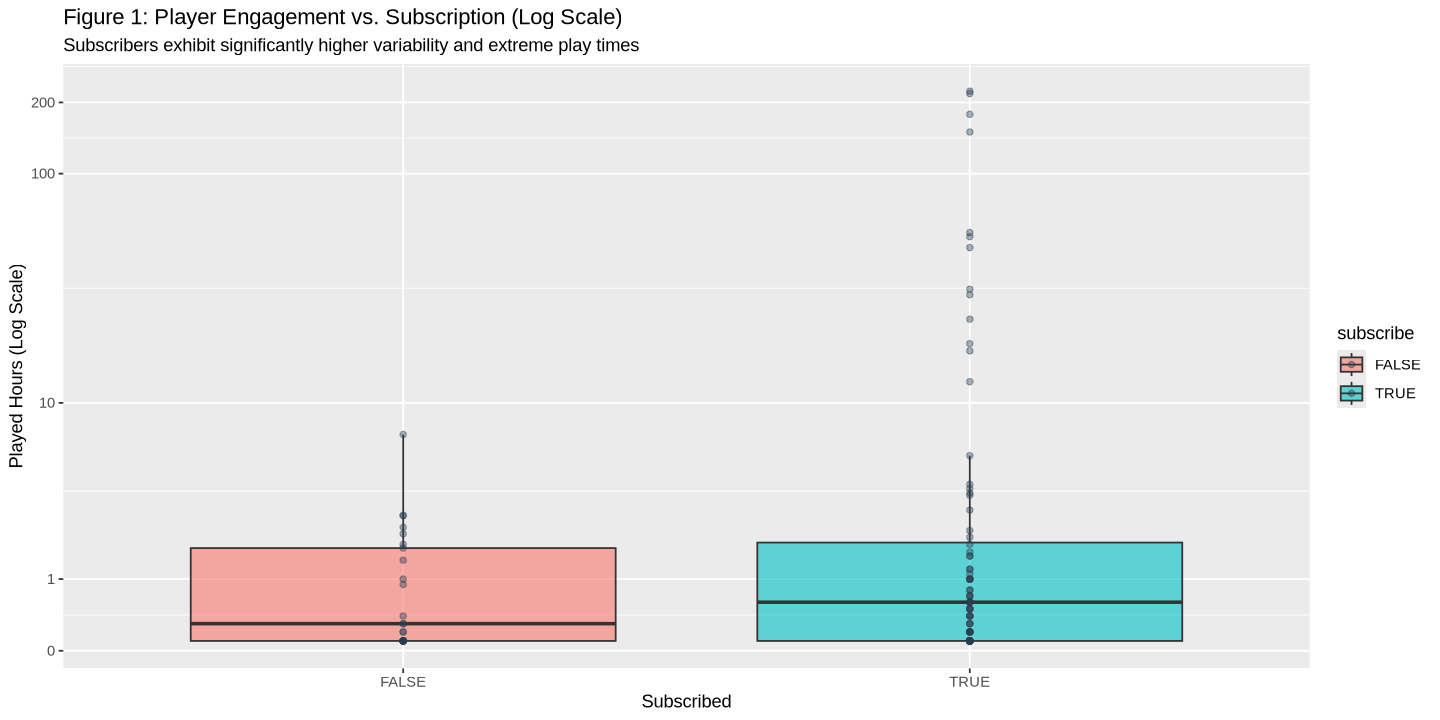

In [8]:
# Visualizations to better understand the data.

# use a log scale to handle the extreme skew and zero values in the data
minecraft_plot1 <- ggplot(players_new, aes(x = subscribe, y = played_hours, fill = subscribe)) +
  geom_boxplot(outlier.shape = NA, alpha = 0.6) + # Boxplot summarizes distribution
  geom_point(alpha = 0.4, color = "#2C3E50") + # Point shows actual data density
  scale_y_continuous(trans = "log1p", breaks = c(0, 1, 10, 100, 200)) + # Log transformation for readability
  labs(
    title = "Figure 1: Player Engagement vs. Subscription (Log Scale)",
    subtitle = "Subscribers exhibit significantly higher variability and extreme play times",
    x = "Subscribed",
    y = "Played Hours (Log Scale)"
  )

minecraft_plot1

# Detailed statistics for played hours to support the Discussion
hours_stats <- players_new %>%
  group_by(subscribe) %>%
  summarise(
    count = n(),
    median_hours = median(played_hours),
    mean_hours = mean(played_hours),
    max_hours = max(played_hours),
    # Percentage of players with effectively zero playtime
    pct_inactive = mean(played_hours == 0) * 100
  )

hours_stats

**Figure 1**: Note that the Y-axis uses a logarithmic scale because the difference in play times is extreme (ranging from 0 to over 200 hours).  
There is a clear "ceiling" for non subscribers. While low playtime does not guarantee a player won't subscribe (many subscribers also have low hours), high playtime is a near perfect predictor of subscription. Essentially, the most dedicated players are almost exclusively subscribers, whereas casual players are a mix of both.

List of 1
 $ text:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 14
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

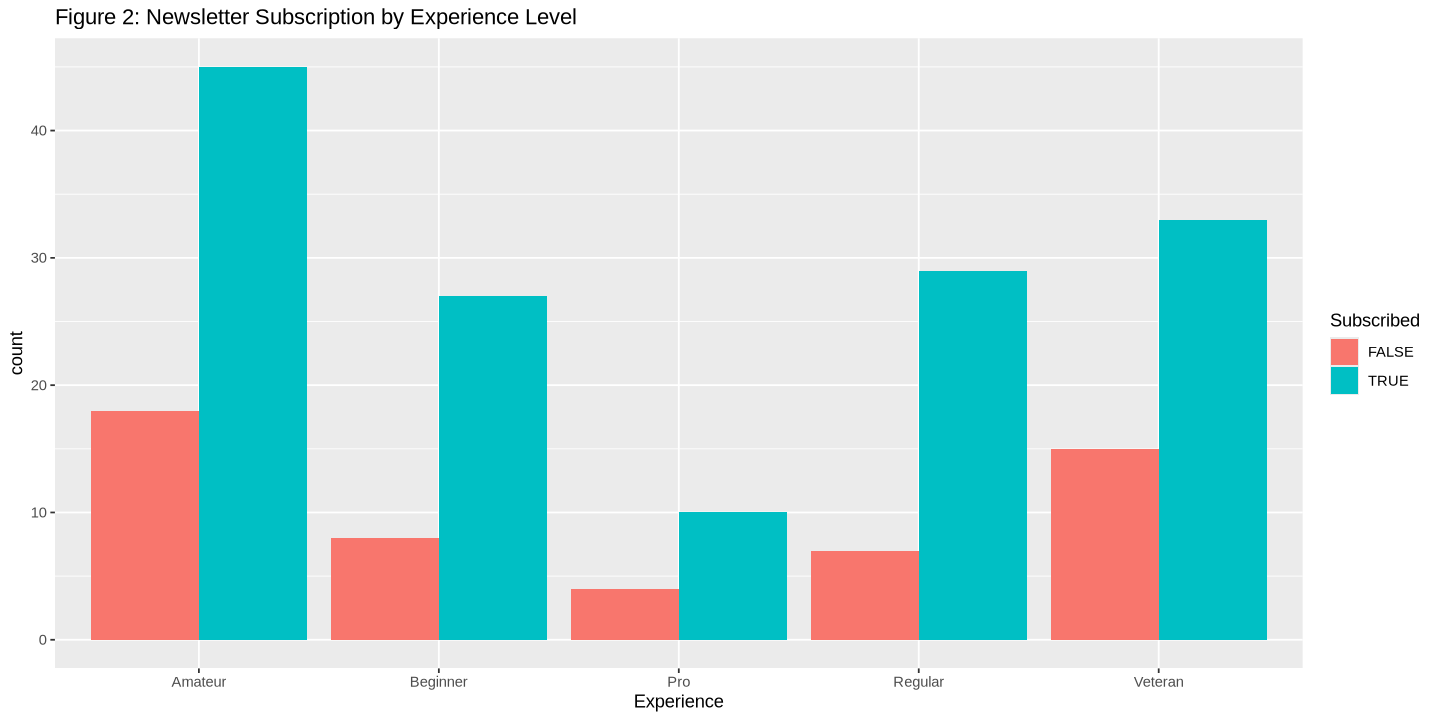

In [9]:
# Visualization: Subscription by Experience
minecraft_plot2 <- ggplot(players, aes(x = experience, fill = factor(subscribe))) +
  geom_bar(position = "dodge") +
  labs(title = "Figure 2: Newsletter Subscription by Experience Level", 
       x = "Experience", fill = "Subscribed")
    theme(text = element_text(size = 14))

minecraft_plot2

**Figure 2**: Subscription rates follow a concave pattern: amateurs and veteran players subscribe more often, especially amateurs, while mid-level players show noticeably lower subscription counts. This non-linear trend suggests that experience level may influence subscription behavior in a more complex way than expected.

List of 1
 $ text:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 14
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


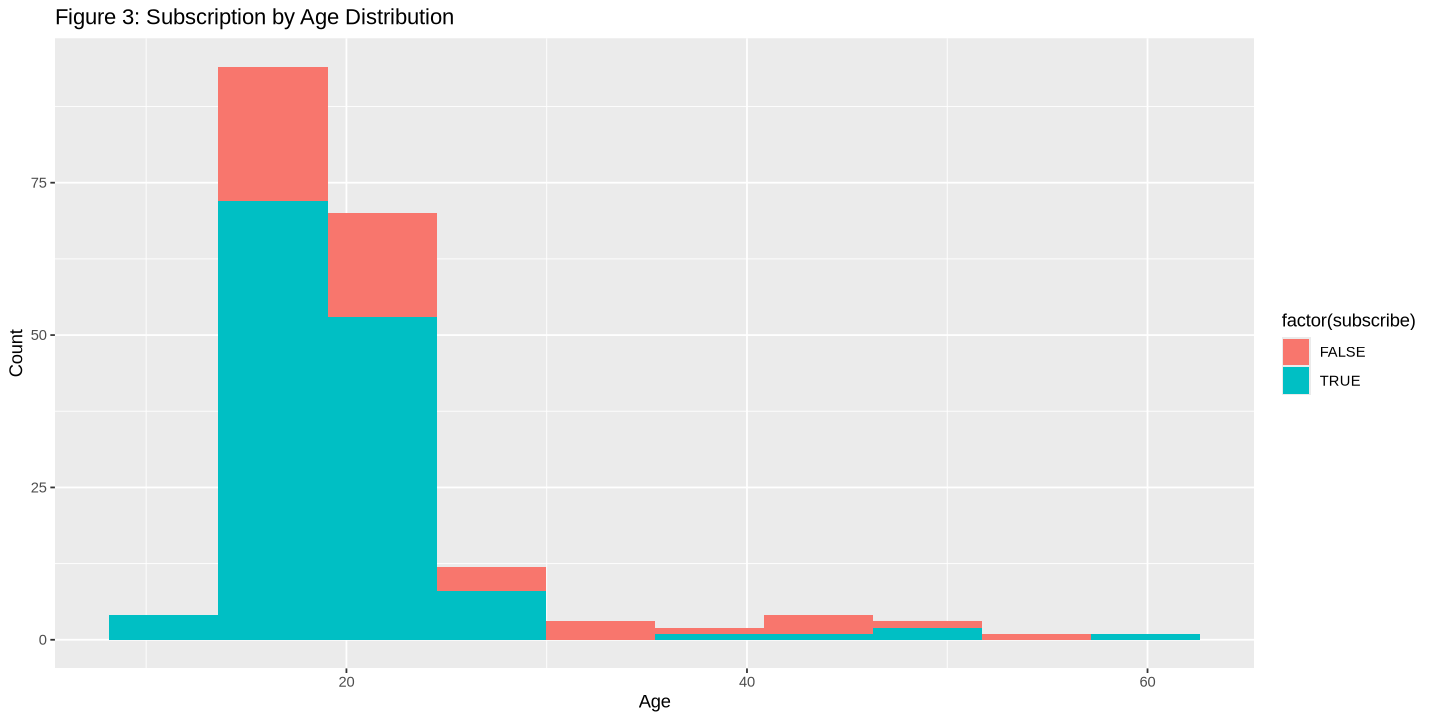

In [10]:
# Histogram: Subscription by Age Distribution
minecraft_plot3 <- ggplot(players, aes(x = Age, fill = factor(subscribe))) +
  geom_histogram(bins = 10, position = "stack") +
  labs(title = "Figure 3: Subscription by Age Distribution", x = "Age", y = "Count")
    theme(text = element_text(size = 14))

minecraft_plot3

**Figure 3**: Here we can see that the Age vs Subscrition graph only highlights and focuses on a significant number of the player base - that being those who are 17. Therefore, this may pose an issue when classifying and impacting our precision/recall values. 

Additionally, the majority of participants' ages range from 17-28, so we may not be able to display results for experience levels of people outside of the age range. 

## Analysis  


**K-Nearest Neighbours (KNN)**

To predict the binary outcome (subscribe: TRUE/FALSE), we employed a K-Nearest Neighbours (KNN) classifier. This method predicts a player’s subscription status based on the subscription behaviour of the most similar players in the dataset, using their Age, played_hours, and experience.

**Procedure:**

Data Splitting: We used the same data split as for logistic regression, with 75% of the data used for training and 25% held out for testing to evaluate performance on unseen data.

Preprocessing: Because KNN is distance-based and sensitive to the scale of predictors, we standardised the numeric variables (Age, played_hours, and experience) in the training set and applied the same transformation to the test set.

Model Specification: We specified a KNN classification model using the tidymodels framework.

Model Tuning: Using K-fold cross-validation on the training data, we compared different values of K and selected the one that gave the best average classification performance.

Training: The final KNN model with the chosen K was then fitted on the full training set, and its predictive performance was evaluated on the test set.


In [11]:
library(tidymodels)

set.seed(123)

# 1. Split the data into training (75%) and test (25%) sets,
sub_split  <- initial_split(players_new, prop = 0.75, strata = subscribe)
sub_train  <- training(sub_split)
sub_test   <- testing(sub_split)

# 2. Define a recipe:
knn_recipe <- recipe(subscribe ~.,
                     data = sub_train) |>
  step_normalize(all_numeric_predictors())

# 3. Specify the KNN classification model.
knn_spec <- nearest_neighbor(
  mode        = "classification",
  neighbors   = tune(),        # K will be selected via cross-validation
  weight_func = "rectangular",
  dist_power  = 2
) |>
  set_engine("kknn")

# 4. Create a workflow that combines the recipe and the model specification.
knn_wf <- workflow() |>
  add_model(knn_spec) |>
  add_recipe(knn_recipe)

# 5. Set up 5-fold cross-validation on the training set.
set.seed(123)
knn_folds <- vfold_cv(sub_train, v = 5, strata = subscribe)

# 6. Define a grid of candidate K values to try.
knn_grid <- tibble(neighbors = seq(1, 31, by = 2))  # K = 1, 3, 5, ..., 31

# 7. Tune the KNN model over the grid of K values using cross-validation.
knn_tuned <- tune_grid(
  knn_wf,
  resamples = knn_folds,
  grid      = knn_grid,
  metrics   = metric_set(accuracy)
)

# 8. Inspect the best-performing K values according to accuracy.
show_best(knn_tuned, "accuracy")

# 9. Select the single best K based on cross-validated accuracy.
best_knn <- select_best(knn_tuned, "accuracy")

# 10. Finalize the workflow by plugging in the best K.
final_knn_wf <- finalize_workflow(knn_wf, best_knn)

# 11. Fit the final KNN model on the full training set.
final_knn_fit <- fit(final_knn_wf, data = sub_train)

# 12. Generate predictions on the test set:
knn_test_preds <- predict(final_knn_fit, sub_test, type = "prob") |>
  bind_cols(predict(final_knn_fit, sub_test)) |>
  bind_cols(sub_test |> select(subscribe))

# 13. Compute overall performance metrics on the test set,
knn_metrics <- knn_test_preds |>
  metrics(truth = subscribe, estimate = .pred_class)

# 14. Create a confusion matrix to see how the model performs
#     on each class (subscribe = TRUE/FALSE).
knn_conf_mat <- knn_test_preds |>
  conf_mat(truth = subscribe, estimate = .pred_class)

knn_metrics
knn_conf_mat


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
13,accuracy,binary,0.7788235,5,0.008645258,Preprocessor1_Model07
15,accuracy,binary,0.7788235,5,0.008645258,Preprocessor1_Model08
17,accuracy,binary,0.7788235,5,0.008645258,Preprocessor1_Model09
19,accuracy,binary,0.7788235,5,0.008645258,Preprocessor1_Model10
21,accuracy,binary,0.7788235,5,0.008645258,Preprocessor1_Model11


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.75
kap,binary,0.00


          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE      7   21

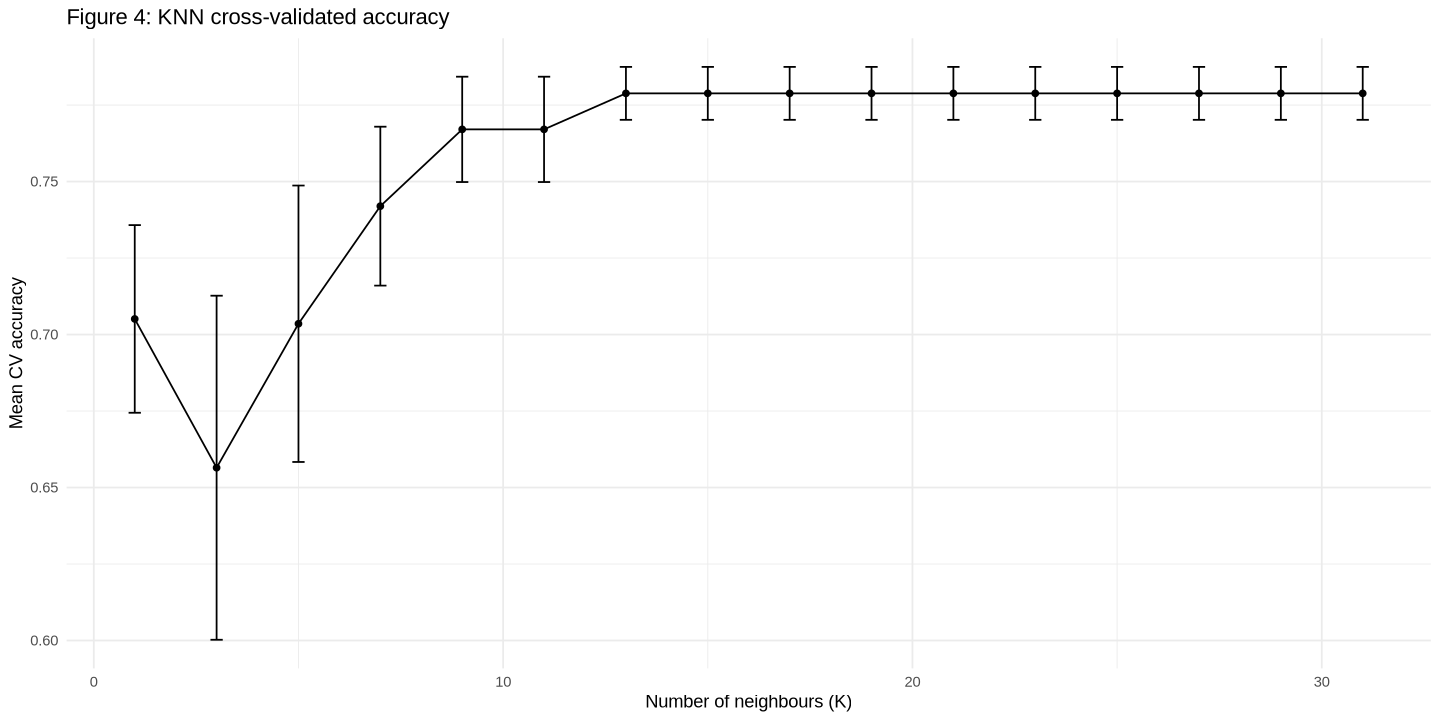

In [12]:
library(ggplot2)

# Collect cross-validation metrics for each value of K
knn_cv_results <- knn_tuned |>
  collect_metrics() |>
  filter(.metric == "accuracy")


# Plot mean accuracy vs. number of neighbours (K)
ggplot(knn_cv_results, aes(x = neighbors, y = mean)) +
  geom_line() +                          # connect the points with a line
  geom_point() +                         # show each K as a point
  geom_errorbar(aes(ymin = mean - std_err,
                    ymax = mean + std_err),
                width = 0.3) +           # add error bars for uncertainty
  labs(
    title = "Figure 4: KNN cross-validated accuracy",
    x = "Number of neighbours (K)",
    y = "Mean CV accuracy"
  ) +
  theme_minimal()


Figure 4: The cross-validation results in Figure X show that the KNN classifier performs poorly for very small values of K, but its mean accuracy increases as K becomes larger. From about K=9 onwards, the cross-validated accuracy stabilises around 0.78 with relatively small standard errors. This suggests that using more neighbours helps to smooth out noise in individual observations and leads to more reliable predictions. We therefore chose a value of K in this flat region of the curve (e.g., K=15), where the model achieves high and stable cross-validated accuracy without being overly sensitive to small changes in K.

### Logistic Regression  
To predict the binary outcome (subscribe: TRUE/FALSE), we also employed a Logistic Regression model. This method allows us to estimate the probability of a player subscribing based on the explanatory variables (Age, played_hours, and experience).  

#### Procedure:

1. Data Splitting: The data was split into training (75%) and testing (25%) sets to evaluate model performance on unseen data.

2. Model Specification: We used the glm engine in the tidymodels framework.

3. Training: The model was trained using the training set.

In [13]:
set.seed(123) # Ensure reproducibility

# 1. Split the data into training and testing sets
data_split <- initial_split(players_new, prop = 0.75, strata = subscribe)
train_data <- training(data_split)
test_data  <- testing(data_split)

# 2. Define the model specification
log_mod <- logistic_reg() %>%
  set_engine("glm") %>%
  set_mode("classification")

# 3. Create a recipe for preprocessing
# We convert nominal predictors (experience, gender) into dummy variables
player_recipe <- recipe(subscribe ~ ., data = train_data) %>%
  step_dummy(all_nominal_predictors())

# 4. Create a workflow
player_workflow <- workflow() %>%
  add_model(log_mod) %>%
  add_recipe(player_recipe)

# 5. Fit the model to the training data
player_fit <- player_workflow %>%
  fit(data = train_data)

# Output the model coefficients (Reasoning)
tidy(player_fit)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.66412271,0.96187163,1.73008815,0.08361453
played_hours,0.07056764,0.07685994,0.91813287,0.35854931
Age,-0.02047364,0.03605550,-0.56783675,0.57014582
experience_Beginner,-0.34272627,0.77824752,-0.44038209,0.65966040
experience_Pro,-1.06890749,0.93543849,-1.14268067,0.25317120
experience_Regular,0.38823169,0.93263828,0.41627252,0.67721060
experience_Veteran,-0.05490371,0.76287321,-0.07196965,0.94262606


We evaluated the model using the testing set. We visualized the results using a Confusion Matrix to see true positives and false negatives, and calculated the overall accuracy.

# A tibble: 1 × 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy binary          0.75


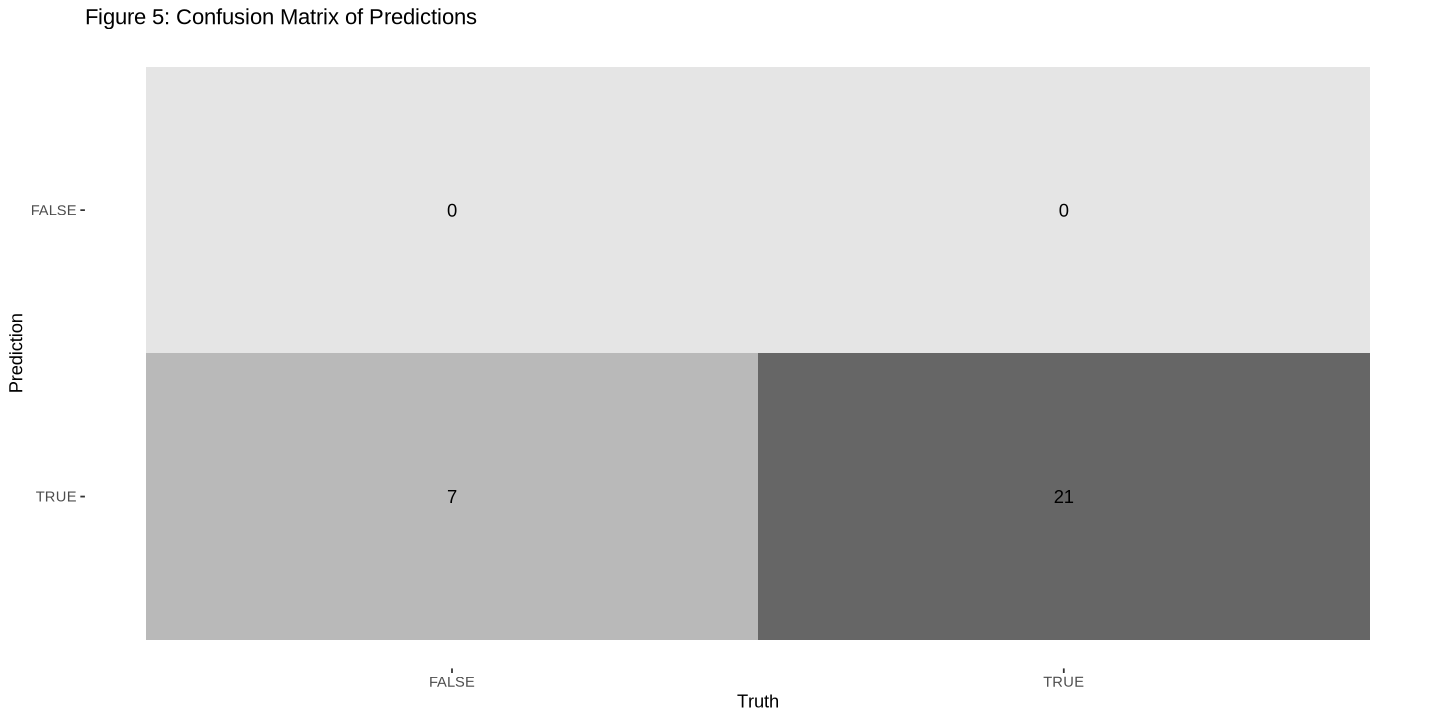

In [14]:
# Predict on test data
predictions <- player_fit %>%
  predict(test_data) %>%
  bind_cols(test_data)

# Confusion Matrix Visualization
conf_mat <- predictions %>%
  conf_mat(truth = subscribe, estimate = .pred_class)

# Figure 5: Heatmap of the Confusion Matrix
autoplot(conf_mat, type = "heatmap") +
  labs(title = "Figure 5: Confusion Matrix of Predictions")

# Calculate Accuracy
accuracy_metric <- predictions %>%
  metrics(truth = subscribe, estimate = .pred_class) %>%
  filter(.metric == "accuracy")

print(accuracy_metric)

Figure 5 shows the confusion matrix for the final model on the test set. The model predicts every player as a subscriber (TRUE): it correctly identifies all 21 actual subscribers, but misclassifies all 7 non-subscribers as subscribers. Thus, while the overall accuracy is 0.75, the model has perfect sensitivity but zero specificity, reflecting the imbalance in the data and its bias toward the majority “subscribe” class.


# III. Discussion
### Summary of Findings  
Our analysis aimed to identify predictors for newsletter subscriptions. Based on the Exploratory Data Analysis, KNN classification and the Logistic Regression coefficients, we observed specific trends. For example, preliminary EDA (Figure 2) suggested that "Veterans" and "Amateurs" constituted a large portion of the subscriber base. The logistic regression model provided quantitative backing to these observations, assigning weights (coefficients) to the experience levels and age. It showed that while age seemed to have some impact on subscription chances, largely veterency played a much stronger role in subscriptions. 

The KNN classifier told a similar story. Using cross-validation, we found that values of (K) between about 13 and 21 gave the highest mean accuracy (around 0.78). When we evaluated the final KNN model and the logistic regression model on the same test set, both achieved an accuracy of 0.75. However, their confusion matrices looked almost identical: each model predicted every player as a subscriber (TRUE), correctly classifying all 21 subscribers but misclassifying all 7 non-subscribers. This means that in practice, both models mainly capture who is likely to subscribe, but they do not successfully pick out the smaller group of non-subscribers.

### Expectations vs. Reality  
We expected played_hours to be a strong predictor, assuming that players who play more are more invested in the game's ecosystem. However, the high variance in play time (shown in the summary statistics) likely introduced noise, making it a less reliable predictor than categorical experience levels, which are much more concrete. The model's accuracy on the test set indicates how well these specific demographics generalize to new players, with higher accuracy levels returning more responses from the playerbase. 

We also expected that the more flexible KNN model might separate subscribers and non-subscribers better than logistic regression. In reality, both models behaved very similarly on the test set and defaulted to predicting the majority class (“subscribe”) for everyone. The test accuracy of 0.75, therefore, reflects how well the models identify typical subscribers rather than their ability to distinguish non-subscribers. This highlights the effect of our small, imbalanced sample: a model can have reasonable accuracy while still having zero specificity.

### Impact  
These findings have immediate implications for the marketing team. If specific experience levels (e.g., Veterans) are statistically more likely to subscribe, resources should not be wasted aggressively targeting them as they are already likely to convert. Instead, efforts can be focused on the segments identified as "low probability" subscribers to increase their engagement, or simply accepted as a segment that prefers other communication channels. Examples of these parties are low veteran players or possibly players who seem to intentionally have lower playtimes. 

At the same time, the fact that both models classify everyone as a subscriber means that we should be cautious about using them to target non-subscribers. The models are more useful for confirming which groups are highly engaged, rather than for precisely identifying players who are unlikely to subscribe and need special attention.


### Future Questions  
1. Content Relevance: Do younger players prefer real-time communication (such as social media) over newsletters?

2. Churn Analysis: Does subscription actually lead to longer retention, or is it just a signal of existing loyalty? Future analysis should treat subscribe as a predictor for retention_rate.

3. Feature Engineering: Could early-game behavior, session frequency, or engagement bursts serve as better real-time predictors?

4. Player Motivations: What role do intrinsic motivations, such as competition, exploration, or social play, play in subscription probability? Is this measurable via this data set?

5. Model improvement: How would our results change if we addressed the class imbalance (e.g., re-weighting or resampling) or tuned the classification threshold so that models trade some sensitivity for better specificity when identifying non-subscribers?

# References

Pacific Laboratory for Artificial Intelligence. (2025, September 11). *Pacific Laboratory for Artificial Intelligence.* https://plai.cs.ubc.ca/ 

*PLAICraft. (n.d.).* https://plaicraft.ai/